In [1]:
import numpy as np
import scipy.stats # utilisé pour le génération de points
import matplotlib.pyplot as plt

### E-step
$\gamma\left(z_{n k}\right)=\frac{\pi_{k} N\left(x_{n} | \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} N\left(x_{n} | \mu_{j}, \Sigma_{j}\right)}$
<br>
### M-step
$\begin{array}{l}
{\pi_{k}^{n e w}=\frac{N_{k}}{N}, \mu_{k}^{n e w}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) x_{n}, \Sigma_{k}^{n e w}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(x_{n}-\mu_{k}^{n e w}\right)\left(x_{n}-\mu_{k}^{n e w}\right)^{T}} \\
{\text {where } N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}
\end{array}$

### Hyperparameters

In [78]:
# Nombre réel de clusters
K_real = 4 # utilisé uniquement dans la génération des échantillons

# nombre de clusters à utiliser pour la prédiction
K = 4 # utilisé pour la prédiction

# Nombre d'échantillons par cluster
N_k = 100

# Nombre total d'échantillons
N = N_k * K_real

### Sample generation

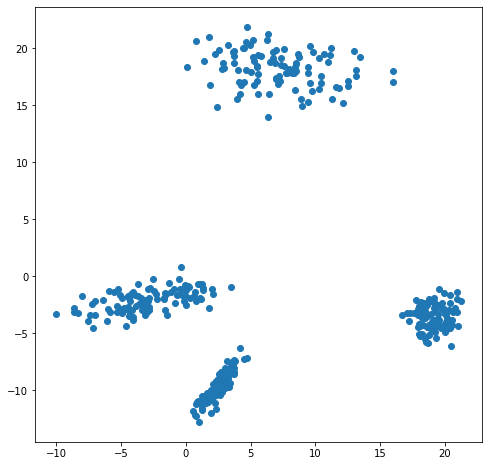

In [79]:
np.random.seed(1340)

samples = []
for _ in range(K_real):
    # Échantillonner un vecteur.
    mean = np.random.normal(size = 2) * 10
    
    # Échantillon de la distribution Wishart pour créer une matrice de covariance aléatoire.
    cov = scipy.stats.wishart.rvs(3, scale=[[1, 0], [0, 1]])
    
    # Obtenir N_k échantillons de la distribution normale multivariée 
    # avec la moyenne et la covariance échantillonnées ci-dessus.
    samples.append(np.random.multivariate_normal(mean, cov, size=N_k)) # N_k = 100
    
#shape: (N, 2), concaténer pour convertir la liste en tableau numpy.
samples = np.concatenate(samples, axis=0)

# Visualizaiton
plt.figure(figsize=[8, 8])
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

**Points générés :**

In [80]:
mean

array([19.10574279, -3.41240753])

In [81]:
cov

array([[ 0.81936555, -0.01788411],
       [-0.01788411,  1.13329795]])

In [82]:
print(samples[0:4])

[[  2.35128883 -10.19109697]
 [  2.56492696  -9.56499429]
 [  3.74505142  -8.5869103 ]
 [  1.91892297 -12.01420151]]


### E-step
$\gamma\left(z_{n k}\right)=\frac{\pi_{k} N\left(x_{n} | \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} N\left(x_{n} | \mu_{j}, \Sigma_{j}\right)}$

In [83]:
def E_step(pis, means, covs, samples):
    '''
    Trouvez la probabilité que chaque échantillon appartienne à chaque cluster.
    
    arguments
    pis: (K), coefficient de K clusters
    means: (K, 2), moyenne des K clusters
    covs: (K, 2, 2), la matrice de covariance de K clusters
    samples: (N, 2), un vecteur de N échantillons
    
    returns
    responsibilities: (N, K), probabilité que N échantillons appartiennent à K clusters
    '''
    
    # shape: (N, K), créez une variable pour stocker la probabilité que chaque échantillon appartienne à K clusters.
    # N : Nombre total d'échantillons
    # K : Nombre de clusters à utiliser pour la prédiction
    responsibilities = np.zeros([N, K])

    for k in range(K): # Pour chaque cluster
        # forme: (N), multipliant le likelihood pour obtenir la responsabilité.
        responsibility = pis[k] * 
        responsibilities[:, k] = responsibility
        
    # Normalization
    responsibilities = responsibilities / np.sum(responsibilities, axis=1)[:, None]
        
    return responsibilities

### M-step
$\begin{array}{l}
{\pi_{k}^{n e w}=\frac{N_{k}}{N},\\
\mu_{k}^{n e w}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) x_{n}, \\
\Sigma_{k}^{n e w}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(x_{n}-\mu_{k}^{n e w}\right)\left(x_{n}-\mu_{k}^{n e w}\right)^{T}} \\
{\text {where } N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}
\end{array}$

In [84]:
def M_step(responsibilities, samples):
    for k in range(K):
        # shape: scalaire, somme des responsabilités par cluster
        N_k = np.sum(responsibilities[:, k])
        
        # scalaire, coefficient du kème cluster
        pis[k] = N_k / N
        
        # shape: (2), moyenne du k-ème cluster
        means[k] = np.sum(responsibilities[:, k][:, None] * samples, axis=0) / N_k
        
        # shape: (N, 2, 1), différence entre les échantillons et la moyenne
        diffs = (samples - means[k])[:, :, None]
        
        # matrice de covariance du k-ème cluster
        cov = np.zeros([2, 2])
        for n in range(N): # N : Nombre total d'échantillons
            cov += responsibilities[n, k] * diffs[n] @ diffs[n].T # @ : Multiplication de matrices 
        covs[k] = cov / N_k
        
    return pis, means, covs

### Plotting

In [85]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import colors
from matplotlib import cm

# reference : https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(ax, pi, mean, cov, n_std=3.0, facecolor='none', **kwargs):
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        alpha=pi * 0.5,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot(ax, samples, responsibilities, pis, means, covs, title):
    cluster_colors = cm.get_cmap('Set1').colors
     
    for k in range(K):
        rgba = colors.to_rgba(cluster_colors[k % len(cluster_colors)])
        rgba_n = np.array([rgba for _ in range(N)])
        rgba_n[:, 3] = responsibilities[:, k]
        
        ax.scatter(samples[:, 0], samples[:, 1], color=rgba_n)
        ax.scatter(means[k, 0], means[k, 1], marker='x', color='black', alpha=min(pis[k] * K, 1.0))
        confidence_ellipse(ax, pis[k], means[k], covs[k], facecolor=rgba, edgecolor=rgba)
    
    ax.set_title(title)

### EM Iteration

iteration : 0


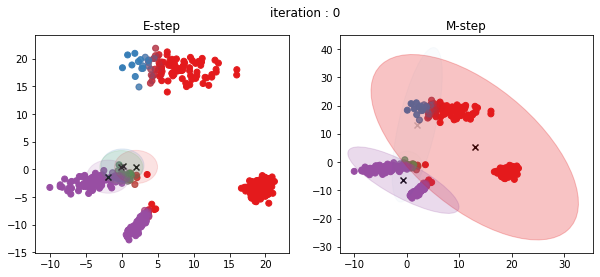

iteration : 10


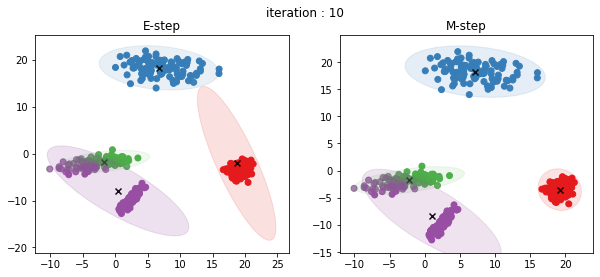

iteration : 20


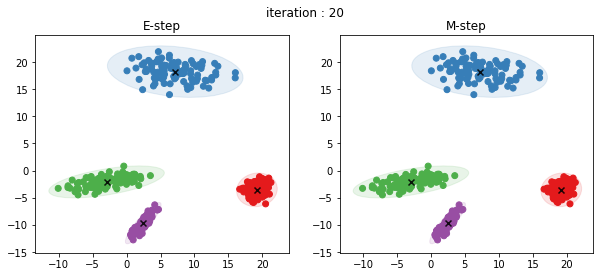

iteration : 30


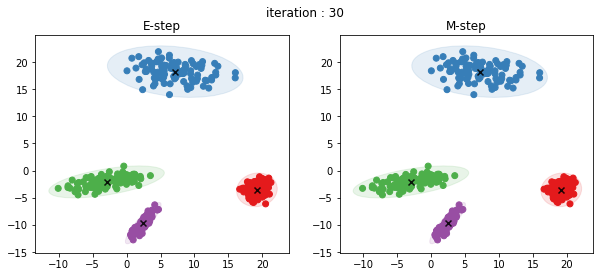

iteration : 40


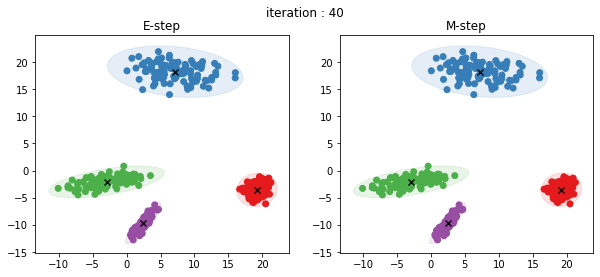

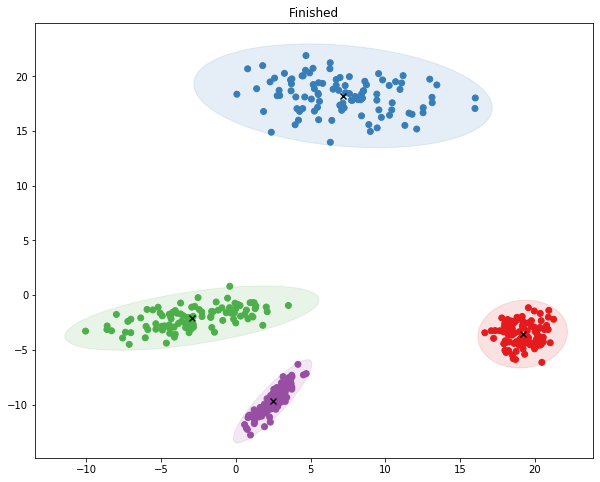

In [86]:
                                    ''' Initialisation des paramètres '''

# Initialise K coefficients de manière égale.
pis = np.ones(K) / K

# Nous initialisons K randomly.
means = np.random.normal(size=[K, 2])

# Initialiser les matrices de covariance K à l'indentité.
covs = [np.array([[1, 0], [0, 1]]) for _ in range(K)]

for step in range(50):
    
    #E-step: Trouve la probabilité que chaque échantillon appartienne à chaque cluster.
    responsibilities = E_step(pis, means, covs, samples)
    
    if step % 10 == 0:
        print('iteration :', step)
        fig, axs = plt.subplots(1, 2, figsize=[10, 4])
        fig.suptitle('iteration : ' + str(step))
        plot(axs[0], samples, responsibilities, pis, means, covs, 'E-step')
    
    # M-step: Mettre à jour les matrices de coefficients, de moyennes 
    # et de covariances en fonction de la responsabilité définie dans l'étape E.
    pis, means, covs = M_step(responsibilities, samples)
        
    if step % 10 == 0:
        plot(axs[1], samples, responsibilities, pis, means, covs, 'M-step')
        plt.show()

fig, ax = plt.subplots(1, 1, figsize=[10, 8])
plot(ax, samples, responsibilities, pis, means, covs, 'Finished')
plt.show()